In [1]:
# Importing dependencies
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Reading and splitting data

In [2]:
'''
    Reading and dividing the data
'''
# Read CSV files
train_data = pd.read_csv("./OccupancyTrain.csv", header=None)
test_data = pd.read_csv("./OccupancyTest.csv", header=None)
# Investigating data
print(train_data.head())
print(test_data.head())

# Divide into train and test
x_train = train_data.iloc[:,:-1].values
y_train = train_data.iloc[:,-1].values
x_test = test_data.iloc[:,:-1].values
y_test = test_data.iloc[:,-1].values

# Combined data
df_combined = pd.concat([train_data, test_data])
print(df_combined.shape)
print(train_data.shape)
print(test_data.shape)
print(len(df_combined[df_combined.iloc[:,-1]==1.0]))
print(len(df_combined[df_combined.iloc[:,-1]==0.0]))

       0     1       2        3         4    5
0  21.29  21.1    0.00   592.50  0.003297  0.0
1  22.10  26.6  464.00  1073.25  0.004375  1.0
2  19.39  27.2    0.00   463.00  0.003783  0.0
3  20.60  19.5    0.00   435.00  0.002919  0.0
4  21.50  33.5  475.25  1281.50  0.005320  1.0
       0          1       2            3         4    5
0  23.10  29.700000  466.50  1224.666667  0.005198  1.0
1  19.79  36.200000   24.00   507.500000  0.005172  0.0
2  20.39  32.290000    0.00   684.000000  0.004785  0.0
3  21.50  32.090000  440.25   619.000000  0.005094  1.0
4  21.29  26.683333  454.00   895.166667  0.004176  1.0
(1000, 6)
(600, 6)
(400, 6)
500
500


# Exercise 1
## Visualization / 10 points

In [3]:
# Distribution
# Defining plot variables
df_combined_lc = train_data.iloc[:,-1] 
unique_values = df_combined_lc.unique()
bins = [unique_values[0] - .5, (unique_values[0] + unique_values[1]) / 2, unique_values[1] + .5]
counts = [len(df_combined[df_combined.iloc[:,-1]==0.0]), len(df_combined[df_combined.iloc[:,-1]==1.0])]

# Defining plot
plt.figure(figsize=(4, 4))
plt.bar([0.0, 1.0], counts, color=["indigo", "lightseagreen"])

#plt.hist(df_combined_lc,bins=bins, ec="black", color="mediumseagreen")

# Plot post-processing
plt.xlabel("Occupancy status")
plt.ylabel("Count")
# plt.title("Distribution: Occupancy status")
plt.xticks(unique_values)
plt.yticks(np.arange(0, 600, step=100))
# plt.margins(x=.25, y=.05)

([<matplotlib.axis.YTick at 0x16364f820>,
 [Text(0, 0, '0'),
  Text(0, 100, '100'),
  Text(0, 200, '200'),
  Text(0, 300, '300'),
  Text(0, 400, '400'),
  Text(0, 500, '500')])

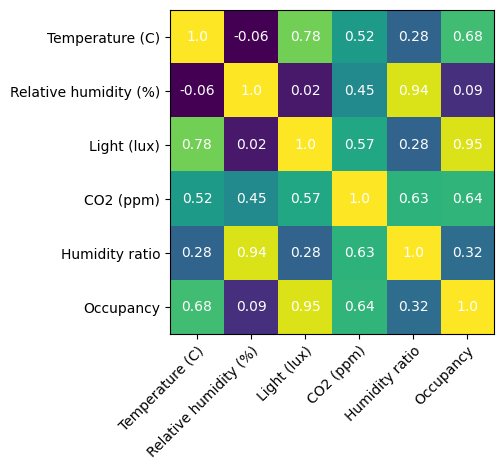

In [4]:
# Correlation
# Headers (From assignment description)
headers = ["Temperature (C)", "Relative humidity (%)", "Light (lux)", "CO2 (ppm)", "Humidity ratio", "Occupancy"]

# Finding correlation
corr = df_combined.corr(method="pearson")

# Showing heatmap
fig, ax = plt.subplots()
im = ax.imshow(corr)

# Setting ticks
plt.xticks(ticks=np.arange(len(headers)), labels=headers)
plt.yticks(ticks=np.arange(len(headers)), labels=headers)

# Rotating ticks
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", 
         rotation_mode="anchor")

# Annotating plot
for i in range(len(headers)):
    for j in range(len(headers)):
        ax.text(j, i, round(corr.iloc[i, j], 2), ha="center", va="center", color="w")

# Customize the plot
fig.tight_layout()

# Exercise 2
## 1-NearestNeighbor / 10 points

In [5]:
'''
CLASS TECHNIQUE
'''
# Defining class
class kNearest:
    # Initialising class
    def __init__(self, k=1):
        self.k = k
        self.X = None
        self.y = None

    # Euclidean distance
    def euclidean_distance(self, model_data, new_data): 
        dist = np.sqrt(np.sum((np.array(model_data) - np.array(new_data))**2))
        return dist

    # Fitting with data
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    # Predicting labels for new data
    def predict(self, new_data):
        y_preds = []
        for data in new_data:
            # Calculate distance to all data
            dists = [self.euclidean_distance(xt_data, data) for xt_data in self.X]

            # Find k smallest indexes
            argMinIdxs = np.argsort(dists)[:self.k]

            # Find and count the labels
            labels = [self.y[idx] for idx in argMinIdxs]
            # Calculate frequenceis for each value
            label_counts = np.bincount(labels)
            # Find max label
            max_label = np.where(label_counts == np.max(label_counts))[0]
            # Append to predicted values
            y_preds.append(max_label)
        return y_preds
            

In [6]:
# Training model
knn = kNearest(k=1)
knn.fit(X=x_train, y=y_train)

In [7]:
'''
DETERMINE ACCURACY
'''
from sklearn.metrics import accuracy_score

pred_train = knn.predict(x_train)
acc_train = accuracy_score(y_train, pred_train)

pred_test = knn.predict(x_test)
acc_test = accuracy_score(y_test, pred_test)

print(f"Accuracy train\t: {acc_train}\nAccuracy test\t: {acc_test}")


Accuracy train	: 1.0
Accuracy test	: 0.9775


# Exercise 3
## Cross-validation / 10 points

In [8]:
# Importing KFold
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def max_kfold(data):
    # Ks and accuracy scores
    ks = [1,3,5,7,9,11]
    accuracy_scores = []

    # Perform kfold cross validation
    cv = KFold(n_splits=5)
    for k in ks:
        accs = []
        for train, test in cv.split(data):
            X_train_cv, y_train_cv, X_test_cv, y_test_cv = data[train], y_train[train], data[test], y_train[test]
            # Creating model
            kneigh = kNearest(k=k)
            kneigh.fit(X_train_cv, y_train_cv)
            pred = kneigh.predict(X_test_cv)
            accs.append(accuracy_score(y_test_cv, pred))
        k_avg = np.mean(accs)
        accuracy_scores.append(k_avg)
    print(accuracy_scores)
    maxk = ks[np.argmax(accuracy_scores)]
    print(f"Best k has been found... k={maxk}")
    return maxk



In [9]:
maxk = max_kfold(x_train)

[0.9816666666666667, 0.9916666666666668, 0.9916666666666668, 0.9916666666666668, 0.9916666666666668, 0.99]
Best k has been found... k=3


# Exercise 4
## k_best model / 10 points

In [10]:
# Initialising and fitting model
knn_best = kNearest(k=maxk)
knn_best.fit(X=x_train, y=y_train)

# Predicting train set accuracy
knn_best_train_pred = knn_best.predict(new_data=x_train)
knn_best_acc_train = accuracy_score(y_true=y_train, y_pred=knn_best_train_pred)

# Predicting test set accuracy
knn_best_test_pred = knn_best.predict(new_data=x_test)
knn_best_acc_test = accuracy_score(y_true=y_test, y_pred=knn_best_test_pred)

# Printing out the results
print(f"Accuracy k_best train\t: {knn_best_acc_train}\nAccuracy k_best test\t: {knn_best_acc_test}")

Accuracy k_best train	: 0.9933333333333333
Accuracy k_best test	: 0.9875


# Exercise 5
## Data normalization / 10 points

In [11]:
# Function for preprocessing data
def preprocessing(copied_data):
    # Finding means and standard deviation for each column
    train_mean = np.mean(x_train, axis=0)
    train_std = np.std(x_train, axis=0)

    # List holder for the normalized data
    norm_data = []
    # Looping each row
    for row in copied_data:
        # Centering and normalizing each row
        normalized_row = np.divide(np.subtract(row, train_mean), train_std)
        norm_data.append(normalized_row)    
    print("Data has been successfully preprocessed...")
    # Returning normalized data
    return np.array(norm_data)

# Using function to normalize the data
# X_combined = np.concatenate((x_train, x_test), axis=0)
# X_normalized = preprocessing(X_combined)
X_train_norm = preprocessing(x_train)
X_test_norm = preprocessing(x_test)

Data has been successfully preprocessed...
Data has been successfully preprocessed...


In [12]:
# # testing
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler().fit(np.concatenate((x_train, x_test)))
# x_train_n = scaler.transform(x_train)
# x_test_n = scaler.transform(x_test)
# n_maxk = max_kfold(x_train_n)

In [13]:
norm_maxk = max_kfold(X_train_norm)

[0.9833333333333334, 0.9916666666666666, 0.9916666666666666, 0.9916666666666666, 0.9899999999999999, 0.9916666666666668]
Best k has been found... k=11


In [14]:
# Initialising and fitting model
knn_best_norm = kNearest(k=norm_maxk)
knn_best_norm.fit(X=X_train_norm, y=y_train)

# Predicting train set accuracy
knn_best_train_norm_pred = knn_best_norm.predict(new_data=X_train_norm)
knn_best_acc_train_norm = accuracy_score(y_true=y_train, y_pred=knn_best_train_norm_pred)

# Predicting test set accuracy
knn_best_test_norm_pred = knn_best_norm.predict(new_data=X_test_norm)
knn_best_acc_test_norm = accuracy_score(y_true=y_test, y_pred=knn_best_test_norm_pred)

# Printing out the results
print(f"Accuracy k_best train normalized\t:\t{knn_best_acc_train_norm}\nAccuracy k_best test normalized\t\t:\t{knn_best_acc_test_norm}")

Accuracy k_best train normalized	:	0.9916666666666667
Accuracy k_best test normalized		:	0.98
